BDLE 2023

date du document  :  29/11/2023 12h

# TP8-9 2023 Traitement parallèle  (SUJET)



L'objectif est de comprendre la notion de traitement sur des données partitionnées.

*   Savoir *décomposer* un traitement complexe en une suite d'étapes.

*   Savoir *séparer* les étapes de **traitement dans une partition** des étapes de **repartitionnement des données**. Dans une étape de traitement, on peut si nécesaire calculer un atribut qui servira à un repartitionnement ultérieur.


Indications:

*   Les données sont gérées par spark et sont supposées être très volumineuses. Elle ne doivent jamais être "remontées" entièrement dans l'application. Ne jamais invoquer un collect() sur la totalité des données.

*   On peut "*remonter*" dans l'application le résultat d'une requête si on sait que sa taille est petite.

*   On peut faire "*descendre*" vers spark des données auxilliaires provenant de l'application (supposées de petite taille). Ces données auxilliaires pourront ensuite être lues lors d'un prochain traitement dans une partition.


Implémentation :

*   Savoir définir une fonction UDF qui implémente le traitement dans une partition et qui est invoquée avec mapPartition ou mapPartitionWithIndex.

*   La fonction repartition permet de repartitionner les données

*   La fonction broadcast permet de diffuser des données auxilliaires




## Préparation du TP

Installer pyspark et findspark (durée 1 min):


In [1]:
!pip install -q pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


installer igraph

In [2]:
!pip install -q igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.6 MB/s eta 0:00:00


In [3]:
import numpy as np

# utilisé pour la détection de composantes connexes
import igraph as ig

# utilisé pour la visualisation d'un graphe
import networkx as nx

Démarrer la session spark

In [4]:
import os
import glob

pyspark_dir = glob.glob('/usr/local/lib/python*/dist-packages/pyspark')[0]
print("pyspark directory is", pyspark_dir)
os.environ["SPARK_HOME"] = pyspark_dir
os.environ["JAVA_HOME"] = "/usr"

pyspark directory is /usr/local/lib/python3.10/dist-packages/pyspark


In [5]:
# Principaux import
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# pour les dataframe et udf
from pyspark.sql import *

import pyspark.sql.functions as f
from pyspark.sql.functions import col

from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "4G").\
  set("spark.driver.memory","4G").\
  set("spark.sql.catalogImplementation","in-memory")

  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")

  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

# pour le TP streaming : 1 seule partition pour avoir un seul fichier de sortie par exécution
spark.conf.set("spark.sql.shuffle.partitions", "1")

session démarrée, son id est  local-1701997120345


In [6]:
# on utilise 4 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "4")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  4


Redéfinir la fonction **display** pour afficher le resutltat des requêtes dans un tableau

In [7]:
import pandas as pd
from google.colab import data_table

# alternatives to Databricks display function.

def display(df, n=100):
  return data_table.DataTable(df.limit(n).toPandas(), include_index=False, num_rows_per_page=10)

def display2(df, n=20):
  pd.set_option('max_columns', None)
  pd.set_option('max_colwidth', None)
  return df.limit(n).toPandas()


Définir le tag **%%sql** pour pouvoir écrire plus simplement des requêtes en SQL dans une cellule

In [8]:
from IPython.core.magic import (register_line_magic, register_cell_magic, register_line_cell_magic)

def removeComments(query):
  result = ""
  for line in query.split('\n'):
    if not(line.strip().startswith("--")):
      result += line + "\n"
  return result

@register_line_cell_magic
def sql(line, cell=None):
    "To run a sql query. Use:  %%sql"
    val = cell if cell is not None else line
    tabRequetes = removeComments(val).split(";")
    derniere = None
    est_requete = False
    for r in tabRequetes:
        r = r.strip()
        if len(r) > 2:
          derniere = spark.sql(r)
          est_requete = ( r.lower().startswith('select')or r.lower().startswith('with'))
    if(est_requete):
      return display(derniere)
    else:
      return print('ok')

## Accès aux données

### URL pour l'accès aux datasets

In [9]:
# URL du dossier PUBLIC_DATASET contenant des fichiers de données pour les TP
# ---------------------------------------------------------------------------
# en cas de problème avec le téléchargement des datasets, aller directement sur l'URL ci-dessous
PUBLIC_DATASET_URL = "https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4"
PUBLIC_DATASET=PUBLIC_DATASET_URL + "/download?path="

print("URL du dossier contenant les datasets ", PUBLIC_DATASET_URL)

URL du dossier contenant les datasets  https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4


In [10]:
local_dir = "/local/data"
os.makedirs(local_dir, exist_ok=True)
os.listdir(local_dir)

[]

In [11]:
from urllib import request

# download dataset if not already donwloaded
def download_file(web_dir, local_dir, file):
  local_file = local_dir + "/" + file
  web_file = web_dir + "/" + file
  if(os.path.isfile(local_file)):
    print(file, "is already stored")
  else:
    print("downloading from URL: ", web_file , "save in : " + local_file)
    request.urlretrieve(web_file , local_file)


# données : graphe de similarité entre protéines

# vider le dossier
!cd /local/data && rm -fr  BDLE*

web_dir = PUBLIC_DATASET + "BDLE_proteine/"
download_file(web_dir, local_dir, "BDLE_10K.zip")
download_file(web_dir, local_dir, "BDLE_1M.zip")

!cd /local/data && unzip BDLE_10K.zip
!cd /local/data && unzip BDLE_1M.zip
!cd /local/data && rm -f  *.zip

os.listdir(local_dir)


downloading from URL:  https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=BDLE_proteine//BDLE_10K.zip save in : /local/data/BDLE_10K.zip
downloading from URL:  https://nuage.lip6.fr/s/H3bpyRGgnCq2NR4/download?path=BDLE_proteine//BDLE_1M.zip save in : /local/data/BDLE_1M.zip
Archive:  BDLE_10K.zip
 extracting: BDLE_10K/._SUCCESS.crc  
 extracting: BDLE_10K/.part-00000-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet.crc  
 extracting: BDLE_10K/.part-00001-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet.crc  
 extracting: BDLE_10K/.part-00002-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet.crc  
 extracting: BDLE_10K/.part-00003-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet.crc  
 extracting: BDLE_10K/_SUCCESS       
  inflating: BDLE_10K/part-00000-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet  
  inflating: BDLE_10K/part-00001-a28884c2-56d1-4493-a72b-1dcebd71d1e0-c000.snappy.parquet  
  inflating: BDLE_10K/part-00002-a28884c2-56d1-4493

['BDLE_10K', 'BDLE_1M']

## Exercice 1A: Calcul centralisé des composantes

On commence par étudier le cas centralisé.
L'objectif est de comprendre qu'on fait appelle à une fonction existante pour le calcul de composantes et que cela induit des déplacements de données entre l'application et Spark. Il y a des déplacements dans les deux sens. On demande de compter:
  * le nombre de tuples déplacés depuis  l'application vers Spark
  * le nombre de tuples déplacés depuis Spark vers l'application

On considère la table  G1(s, d) contenant les arcs d'un graphe:

In [18]:
data1 = """
n1 n2
n2 n3
n3 n1
n4 n5
n4 n6
n4 n8
n7 n5
n7 n6
"""

tab = [line.split(" ") for line in data1.split('\n') if len(line)>0]
tab = [(s, d) for (s, d) in tab]
G1 = spark.createDataFrame(tab, ["s", "d"])
G1.printSchema()
display(G1)

root
 |-- s: string (nullable = true)
 |-- d: string (nullable = true)



,s,d
0,n1,n2
1,n2,n3
2,n3,n1
3,n4,n5
4,n4,n6
5,n4,n8
6,n7,n5
7,n7,n6


Calculer les composantes du graphe

In [19]:

def get_composantes(g):

  # importer le graphe dans l'application depuis spark
  g_pandas = g.toPandas()

  g_ig = ig.Graph(directed=False)

  nlist = pd.concat([g_pandas['s'], g_pandas['d']]).unique()
  elist = g_pandas.to_records(index=False).tolist()

  g_ig.add_vertices(nlist)
  g_ig.add_edges(elist)

  components = g_ig.connected_components(mode='weak')

  # Associer le nom du noeud n avec sa composante comp
  # On obtient la relation (n, comp)
  vertex_comp = zip(g_ig.vs()["name"], components.membership)
  return [(n,comp) for n,comp in vertex_comp]


# durée pour calculer les composantes
t1 = time.time()
composantes_list = get_composantes(G1)
print ("duree : {:.1f} s".format(time.time()-t1))

print(composantes_list)

duree : 0.6 s
[('n1', 0), ('n2', 0), ('n3', 0), ('n4', 1), ('n7', 1), ('n5', 1), ('n6', 1), ('n8', 1)]


Exporter les composantes depuis l'applicatpon vers Spark

In [14]:
composantes = spark.createDataFrame(composantes_list, schema="n string, comp int")
composantes.printSchema()
display(composantes)

root
 |-- n: string (nullable = true)
 |-- comp: integer (nullable = true)



,n,comp
0,n1,0
1,n2,0
2,n3,0
3,n4,1
4,n7,1
5,n5,1
6,n6,1
7,n8,1


Afficher le graphe

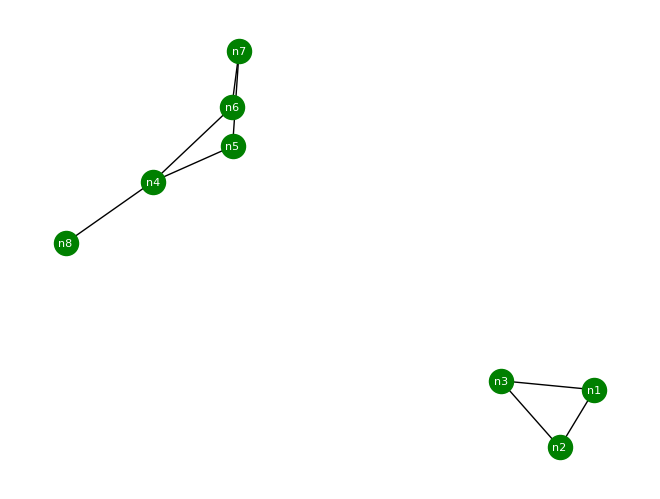

In [20]:
def afficher_graphe(g):
  g_pandas = g.toPandas()

  nlist = pd.concat([g_pandas['s'], g_pandas['d']]).unique()
  elist = g_pandas.to_records(index=False).tolist()

  g_nx = nx.Graph()
  g_nx.add_nodes_from(nlist)
  g_nx.add_edges_from(elist)

  pos = nx.spring_layout(g_nx, iterations = 25)
  nx.draw(g_nx, pos, with_labels="True", node_size=300, font_size='8', node_color= "green", font_color="white")

afficher_graphe(G1)

## Exercice 1B : Calcul décentralisé des composantes

On suppose que les données de G sont distribuées dans deux partitions.
On considère qu'il n'est pas possible de lire les deux partitions pour reconstruire le graphe entier. Autrement dit le plus grand graphe qui peut etre lu est celui d'une seule partition.

L'objectif est de déterminer les composantes de G (on doit obtenir le même résultat que l'exercice précédent) mais en décentralisant le calcul autant que possible.



In [16]:
part0 = """
n1 n2
n3 n1
n7 n5
n4 n6
"""

part1 = """
n7 n6
n4 n5
n4 n8
n2 n3
"""

data = [part0, part1]
G = []

# On considère ici (pour simplifier) que chaque partition est un dataframe séparé

for i in range(2):
  tab = [line.split(" ") for line in data[i].split('\n') if len(line)>0]
  tab = [(s, d) for (s, d) in tab]
  G.append( spark.createDataFrame(tab, ["s", "d"]) )

Afficher le contenu des partitions

In [17]:
print("partition P0")
display(G[0])

partition P0


,s,d
0,n1,n2
1,n3,n1
2,n7,n5
3,n4,n6


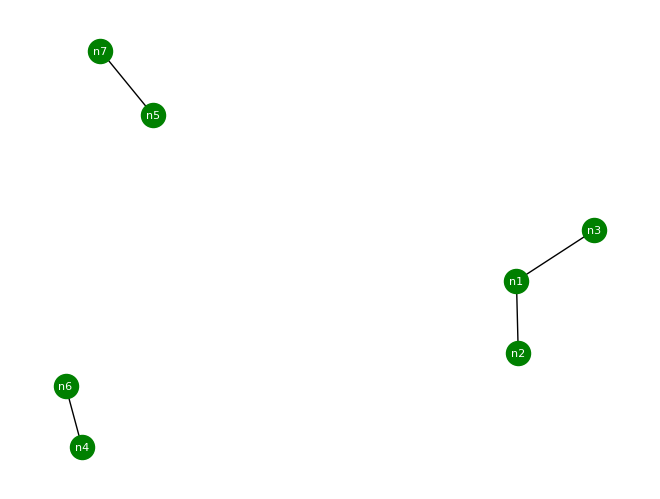

In [18]:
afficher_graphe(G[0])

In [19]:
print("partition P1")
display(G[1])

partition P1


,s,d
0,n7,n6
1,n4,n5
2,n4,n8
3,n2,n3


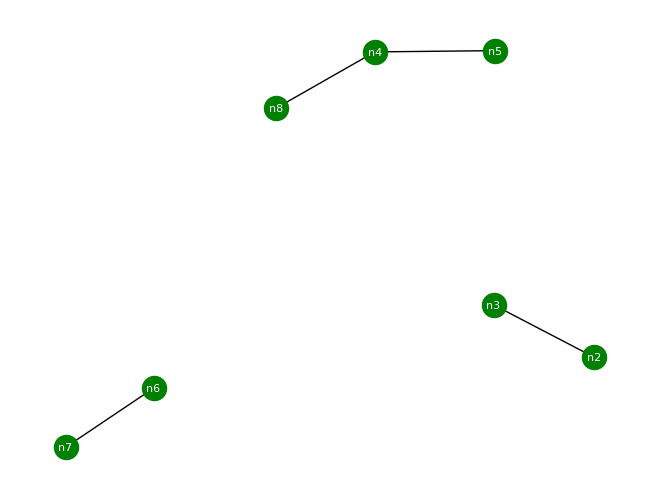

In [20]:
afficher_graphe(G[1])

### **Question a)**

Calculer les composantes de G séparément sur chaque partition P0 et P1.
Obtenir les dataframes
*   G0_comp (partID, n, comp) avec partID valant "P0"
*   G1_comp (partID, n, comp) avec partID valant "P1"



In [21]:
def get_composantes_from_edge_list(edge_list):
  g_ig = ig.Graph(directed=False)

  nlist = []
  [nlist.extend([s,d]) for (s,d) in edge_list]
  nlist = pd.unique(nlist)

  g_ig.add_vertices(nlist)
  g_ig.add_edges(edge_list)

  components = g_ig.connected_components(mode='weak')

  # Associer le nom du noeud n avec sa composante comp
  # On obtient la relation (n, comp)
  vertex_comp = zip(g_ig.vs()["name"], components.membership)
  return [(n,comp) for n,comp in vertex_comp]

In [22]:
composantes_G0 = get_composantes(G[0])
composantes_G1 = get_composantes(G[1])

# Affichage des composantes de chaque partition
print("Le graphe G0 a pour composantes :",composantes_G0)
print("Le graphe G1 a pour composantes :",composantes_G1)

tab0 = [("P0", n, comp) for (n,comp) in composantes_G0]
tab1 = [("P1", n, comp) for (n,comp) in composantes_G1]

G0_comp = spark.createDataFrame(tab0, ["partID", "n", "comp"])
G1_comp = spark.createDataFrame(tab1, ["partID", "n", "comp"])

print("G0_comp:")
display(G0_comp)

Le graphe G0 a pour composantes : [('n1', 0), ('n3', 0), ('n7', 1), ('n4', 2), ('n2', 0), ('n5', 1), ('n6', 2)]
Le graphe G1 a pour composantes : [('n7', 0), ('n4', 1), ('n2', 2), ('n6', 0), ('n5', 1), ('n8', 1), ('n3', 2)]
G0_comp:


,partID,n,comp
0,P0,n1,0
1,P0,n3,0
2,P0,n7,1
3,P0,n4,2
4,P0,n2,0
5,P0,n5,1
6,P0,n6,2


In [23]:
print("G1_comp:")
display(G1_comp)

G1_comp:


,partID,n,comp
0,P1,n7,0
1,P1,n4,1
2,P1,n2,2
3,P1,n6,0
4,P1,n5,1
5,P1,n8,1
6,P1,n3,2


### **Question b)**

Les composantes calculées dans G0_Comp et G1_Comp ont été obtenues indépendamment. On cherche à les "associer".

Est-ce que G0_Comp et G1_Comp ont toujours le même nombre de composantes ?

Est-ce que la composante *i* de P0 contient toujours au moins un noeud commun  avec la composante *i* de P1 ?

On comprend donc que le numéro de composante est interne à une partition : c'est un numéro local et non global à tout le graphe.

Pour obtenir *des numéros de composante globalement uniques*, on propose de préfixer les numéros de composante avec leur numéro de partition.

Restructurer G0_Comp en **G0_comp_unique(n, comp)** pour ajouter un préfixe "P0_" aux numéros de composante de P0 (idem pour P1 respectivement).




In [24]:
G0_pd = G0_comp.toPandas().to_records(index=False).tolist()
tab_comp_unique = [(n,partID+"_"+str(comp)) for partID, n, comp in G0_pd]
G0_comp_unique = spark.createDataFrame(tab_comp_unique, ["n", "comp"])
display(G0_comp_unique)

,n,comp
0,n1,P0_0
1,n3,P0_0
2,n7,P0_1
3,n4,P0_2
4,n2,P0_0
5,n5,P0_1
6,n6,P0_2


In [25]:
G1_pd = G1_comp.toPandas().to_records(index=False).tolist()
tab_comp_unique = [(n,partID+"_"+str(comp)) for partID, n, comp in G1_pd]
G1_comp_unique = spark.createDataFrame(tab_comp_unique, ["n", "comp"])
display(G1_comp_unique)

,n,comp
0,n7,P1_0
1,n4,P1_1
2,n2,P1_2
3,n6,P1_0
4,n5,P1_1
5,n8,P1_1
6,n3,P1_2


### **Question c)**


On veut déterminer quels sont les noeuds présents dans plusieurs composantes.
Or un noeud peut apparaitre à la fois dans G0_comp_unique et G1_comp_unique.

Cependant on ne peut pas réunir G0_comp_unique et G1_comp_unique
dans un seul fichier car il serait trop grand (en général, il peut contenir jusqu'à nombre de noeuds * nombre de partitions lignes).

Ainsi on propose de **répartir**, dans plusieurs dataframes, les données de G0_comp_unique et G1_comp_unique en fonction de la valeur du noeud n.

Séparer les données de G0_comp_unique et G1_comp_unique en deux dataframes tels que:
  * **N1_a_N4**(n,comp) contient toutes les lignes concernant les noeuds 1 à 4.
  * **N5_a_N8**(n,comp) contient toutes les lignes concernant les noeuds 5 à 8.



In [26]:
N1_a_N4_0  = G0_comp_unique.where("n in ('n1','n2','n3','n4')")
N1_a_N4_1  = G1_comp_unique.where("n in ('n1','n2','n3','n4')")
N1_a_N4    = N1_a_N4_0.unionByName(N1_a_N4_1, allowMissingColumns=True)
display(N1_a_N4)

,n,comp
0,n1,P0_0
1,n3,P0_0
2,n4,P0_2
3,n2,P0_0
4,n4,P1_1
5,n2,P1_2
6,n3,P1_2


In [27]:
N5_a_N8_0  = G0_comp_unique.where("n in ('n5','n6','n7','n8')")
N5_a_N8_1  = G1_comp_unique.where("n in ('n5','n6','n7','n8')")
N5_a_N8    = N5_a_N8_0.unionByName(N5_a_N8_1, allowMissingColumns=True)
display(N5_a_N8)

,n,comp
0,n7,P0_1
1,n5,P0_1
2,n6,P0_2
3,n7,P1_0
4,n6,P1_0
5,n5,P1_1
6,n8,P1_1



### **Question d)**

A partir de la relation N1_a_N4 déterminer les paires de composantes
Comp_edges_a(from, to) qui ont un noeud commun et telles que
  * *from* est une composante de P0
  * *to* est une composante de P1.

Effectuer le même calcul à partir de N5_a_N8 pour obtenir Comp_edges_b(from, to)

Puis réunir les résulats obtenus dans une relation qu'on appellera  **Comp_edges**(from, to)




In [42]:
Comp_edges_a = N1_a_N4.withColumn("P", f.expr("substring(comp, 1, 2)"))\
  .groupBy("n").pivot("P").agg(f.expr("first(comp)"))\
  .filter((col("P0").isNotNull()) & (col("P1").isNotNull()))\
  .select(col("P0").alias("from_comp"), col("P1").alias("to_comp")).distinct()


Comp_edges_b = N5_a_N8.withColumn("P", f.expr("substring(comp, 1, 2)"))\
  .groupBy("n").pivot("P").agg(f.expr("first(comp)"))\
  .filter((col("P0").isNotNull()) & (col("P1").isNotNull()))\
  .select(col("P0").alias("from_comp"), col("P1").alias("to_comp")).distinct()

Comp_edges = Comp_edges_a.unionByName(Comp_edges_b, allowMissingColumns=True)

display(Comp_edges)

,from_comp,to_comp
0,P0_0,P1_2
1,P0_2,P1_1
2,P0_2,P1_0
3,P0_1,P1_0
4,P0_1,P1_1


In [34]:
# Juste pour mieux voir
# .filter((col("P0").isNotNull()) & (col("P1").isNotNull()))\

Comp_edges_a_2 = N1_a_N4.withColumn("P", f.expr("substring(comp, 1, 2)"))\
  .groupBy("n").pivot("P").agg(f.expr("first(comp)"))\
  .select(col("n"), col("P0").alias("from_comp"), col("P1").alias("to_comp")).distinct()

# .filter((col("P0").isNotNull()) & (col("P1").isNotNull()))\
Comp_edges_b_2 = N5_a_N8.withColumn("P", f.expr("substring(comp, 1, 2)"))\
  .groupBy("n").pivot("P").agg(f.expr("first(comp)"))\
  .select(col("n"), col("P0").alias("from_comp"), col("P1").alias("to_comp")).distinct()

Comp_edges_2 = Comp_edges_a_2.unionByName(Comp_edges_b_2, allowMissingColumns=True)

display(Comp_edges_2)

,n,from_comp,to_comp
0,n1,P0_0,None
1,n2,P0_0,P1_2
2,n3,P0_0,P1_2
3,n4,P0_2,P1_1
4,n5,P0_1,P1_1
5,n6,P0_2,P1_0
6,n7,P0_1,P1_0
7,n8,None,P1_1


### **Question e)**

On veut calculer les composantes de Comp_edges.

Peux-on dire que la taille de Comp_edges est tres petite par rapport à la taille du graphe G ?
Si oui, est ce qu'on peut réutiliser la méthode de calcul de composantes de la question a)

On obtient **Global_comp**(comp, global_comp)

Dans le meilleur des cas chaque partition contient une/des composante/s entière/s. Dans ce cas, Comp_edges(from_comp, to_comp) est vide, donc taille petite.
Dans le pire des cas, chaque composante a des elements(n) dans chaque partition. Avec des arcs disjoints eparpillés un peu partout, dans ce cas la taille de Comp_edges atteint celle du graphe G.

In [47]:
edge_list = Comp_edges.toPandas().to_records(index=False).tolist()
comp_list = get_composantes(Comp_edges.select(col("from_comp").alias("s"),col("to_comp").alias("d")))

print(f"Le graphe Comp_edges a pour composantes :", comp_list)
# print(f"edge list :", edge_list)

Global_comp = spark.createDataFrame(comp_list, ["comp", "global_comp"])
display(Global_comp)

Le graphe Comp_edges a pour composantes : [('P0_0', 0), ('P0_2', 1), ('P0_1', 1), ('P1_2', 0), ('P1_1', 1), ('P1_0', 1)]


,comp,global_comp
0,P0_0,0
1,P0_2,1
2,P0_1,1
3,P1_2,0
4,P1_1,1
5,P1_0,1


### **Question f)**

En déduire les composantes des noeuds de G :

In [51]:
composantes_pour_N1_a_N4 = N1_a_N4.alias("t1").join(Global_comp.alias("t2"), "comp").select("t1.n","t2.global_comp").distinct()
print("composantes pour les noeuds n1 à n4 :")
display(composantes_pour_N1_a_N4)

composantes pour les noeuds n1 à n4 :


,n,global_comp
0,n1,0
1,n4,1
2,n3,0
3,n2,0


In [52]:
composantes_pour_N5_a_N8 = N5_a_N8.alias("t1").join(Global_comp.alias("t2"), "comp").select("t1.n","t2.global_comp").distinct()
print("composantes pour les noeuds n5 à n8 :")
display(composantes_pour_N5_a_N8)

composantes pour les noeuds n5 à n8 :


,n,global_comp
0,n6,1
1,n7,1
2,n5,1
3,n8,1


### **Question g)**

Compléter G[0] et G[1] avec un attribut *comp* donnant le numéro de composante d'un arc de G

In [103]:
G_comp = []
for G_i in G:
  G_i_min_sd = G_i.withColumn("min_sd", f.least(
      f.expr("CAST(substring(s, 2) AS INT)"),
      f.expr("CAST(substring(d, 2) AS INT)")
  )).withColumn("min_sd", f.concat(f.expr("'n'"), col("min_sd")))

  G_i_comp_N1_a_N4 = G_i_min_sd.join(composantes_pour_N1_a_N4, col("min_sd") == col("n"), "left_outer")\
    .select("s", "d", col("global_comp").alias("comp"))\
    .filter(col("comp").isNotNull())
  G_i_comp_N5_a_N8 = G_i_min_sd.join(composantes_pour_N5_a_N8, col("min_sd") == col("n"), "left_outer")\
    .select("s", "d", col("global_comp").alias("comp"))\
    .filter(col("comp").isNotNull())

  G_i_comp = G_i_comp_N1_a_N4.unionByName(G_i_comp_N5_a_N8, allowMissingColumns=True)



  G_comp.append(G_i_comp)

In [104]:
display(G_comp[0])

,s,d,comp
0,n1,n2,0
1,n3,n1,0
2,n4,n6,1
3,n7,n5,1


In [105]:
display(G_comp[1])

,s,d,comp
0,n2,n3,0
1,n4,n5,1
2,n4,n8,1
3,n7,n6,1


## Exercice 2 : calcul parallèle des composantes

L'objectif est d'intégrer dans Spark la solution de l'exercice précédent pour quelle puisse être traitée en parallèle autant que possible.
La solution doit être assez générale pour fonctionner pour n partitions (avec n pouvant être > 2).

On considère le graphe G stocké dans **un seul** dataframe formé de **plusieurs** partitions.

a) Définir une fonction UDF qui calcule les composantes dans une partition.

b) Invoquer la fonction UDF pour quelle s'exécute en parallèle sur chaque partition.

c) A partir des composantes de chaque partition, définir  le traitement complémentaire pour obtenir les composantes de G de telle sorte que les opérations soient traitées en parallèle. Indication : exprimer les traitements par des requêtes spark pour qu'ils soient traités en parallèle.

Indication : s'inspirer de la fonction topN définie ci-dessous (dans la fonction showPartitions) pour implanter un traitement qui s'applique à l'ensemble des données d'une partition.

In [22]:
data1 = """
n1 n2
n2 n3
n3 n1
n4 n5
n4 n6
n4 n8
n7 n5
n7 n6
"""

tab = [line.split(" ") for line in data1.split('\n') if len(line)>0]
tab = [(s, d) for (s, d) in tab]
G = spark.createDataFrame(tab, ["s", "d"])

# distribuer les données dans 2 partitions
G = G.repartition(2)
print("G a", G.rdd.getNumPartitions(), "partitions")

G.printSchema()
display(G)

G a 2 partitions
root
 |-- s: string (nullable = true)
 |-- d: string (nullable = true)



,s,d
0,n3,n1
1,n1,n2
2,n4,n8
3,n7,n6
4,n4,n5
5,n2,n3
6,n7,n5
7,n4,n6


#### Fonction showPartitions

La fonction *showPartitions*  affiche les _n_ premiers éléments de chaque partition. On ajoute l'attribut partID dans l'affichage pour bien distinguer chaque partition.


In [23]:
#afficher les N premiers_tuples de chaque partition d'un dataframe
def showPartitions(df, N=5, separate=True):
  nb_partitions = df.rdd.getNumPartitions()

  # fonction topN est invoquée sur une partition.
  # topN retourne un itérateur sur une partition qui contient les N premiers éléments de cette partition
  def topN(partID, iterateur):
    c=0
    suivant = next(iterateur, None)
    while suivant is not None and c < N :
      tuple_avec_numero_partition = (partID, *suivant)
      yield tuple_avec_numero_partition
      suivant = next(iterateur, None)
      c+=1

  #-- fin de topN ---


  nom_attributs = ['_partID'] + df.schema.fieldNames()
  premiers_tuples = df.rdd.mapPartitionsWithIndex(topN).toDF(nom_attributs)

  if( separate):
  # afficher séparément le contenu de chaque partition
    for partID in range(nb_partitions):
      print("partition", partID)
      # afficher la partition partID
      premiers_tuples.where(f"_partID={partID}").drop("_partID").show(N, False)
  else:
    # afficher les partitions avec le pseudo attribut _partID
    premiers_tuples.show(N*nb_partitions, False)
    # return display(premiers_tuples, N*nb_partitions)

print('showPartitions définie')

showPartitions définie


Afficher les partitions du graphe

In [14]:
showPartitions(G)

partition 0
+---+---+
|s  |d  |
+---+---+
|n3 |n1 |
|n1 |n2 |
|n4 |n8 |
|n7 |n6 |
+---+---+

partition 1
+---+---+
|s  |d  |
+---+---+
|n4 |n5 |
|n2 |n3 |
|n7 |n5 |
|n4 |n6 |
+---+---+



In [19]:
showPartitions(G, N=3)

partition 0
+---+---+
|s  |d  |
+---+---+
|n3 |n1 |
|n1 |n2 |
|n4 |n8 |
+---+---+

partition 1
+---+---+
|s  |d  |
+---+---+
|n4 |n5 |
|n2 |n3 |
|n7 |n5 |
+---+---+



In [17]:
# afficher les partitions avec le pseudo attribut _partID
showPartitions(G, separate=False)

+-------+---+---+
|_partID|s  |d  |
+-------+---+---+
|0      |n3 |n1 |
|0      |n1 |n2 |
|0      |n4 |n8 |
|0      |n7 |n6 |
|1      |n4 |n5 |
|1      |n2 |n3 |
|1      |n7 |n5 |
|1      |n4 |n6 |
+-------+---+---+



In [18]:
showPartitions(G, separate=False, N=3)

+-------+---+---+
|_partID|s  |d  |
+-------+---+---+
|0      |n3 |n1 |
|0      |n1 |n2 |
|0      |n4 |n8 |
|1      |n4 |n5 |
|1      |n2 |n3 |
|1      |n7 |n5 |
+-------+---+---+



In [24]:
def calculer_composantes(partID, iterateur):
  # importer la partition dans l'application depuis spark
  nset = set()
  elist = []
  suivant = next(iterateur, None)
  while suivant is not None:
    s, d = suivant
    nset.update([s, d])
    elist.append((s, d))
    suivant = next(iterateur, None)
  nlist = list(nset)

  # on crée le graph
  g_ig = ig.Graph(directed=False)
  g_ig.add_vertices(nlist)
  g_ig.add_edges(elist)

  components = g_ig.connected_components(mode='weak')

  # Associer le nom du noeud n avec sa composante comp
  # On obtient la relation (n, comp)
  vertex_comp = zip(g_ig.vs()["name"], components.membership)

  for n,comp in vertex_comp:
    yield (f"P{partID}", n,comp)

In [84]:
df = G

nom_attributs = ['_partID', 'n', 'comp']
composantes = df.rdd.mapPartitionsWithIndex(calculer_composantes).toDF(nom_attributs)
display(composantes)

# G_comp = spark.createDataFrame(df.rdd.mapPartitionsWithIndex(calculer_composantes), nom_attributs)
# display(G_comp)

,_partID,n,comp
0,P0,n2,0
1,P0,n8,1
2,P0,n1,0
3,P0,n3,0
4,P0,n6,2
5,P0,n7,2
6,P0,n4,1
7,P1,n5,0
8,P1,n2,1
9,P1,n3,1


#### Histoire de voir ce qui se passe à l'intérieur

In [82]:
def test_calculer_composantes(partID, iterateur):
  # importer la partition dans l'application depuis spark
  nset = set()
  elist = []
  suivant = next(iterateur, None)
  while suivant is not None:
    s, d = suivant
    nset.update([s, d])
    elist.append((s, d))
    suivant = next(iterateur, None)
  nlist = list(nset)

  for s,d in elist:
    yield (f"P{partID}", s, d)


df = G

nom_attributs = ['_partID', 's', 'd']
tes_composantes = df.rdd.mapPartitionsWithIndex(test_calculer_composantes).toDF(nom_attributs)

display(tes_composantes)

,_partID,s,d
0,P0,n3,n1
1,P0,n1,n2
2,P0,n4,n8
3,P0,n7,n6
4,P1,n4,n5
5,P1,n2,n3
6,P1,n7,n5
7,P1,n4,n6


#### Calcul de Comp_edges (inspiré de la question 1.d)

In [87]:
Comp_edges = Comp_edges = composantes.withColumn("_partID_", f.concat(col("_partID"), f.expr("'_'")))\
  .withColumn("comp",f.concat(col("_partID_"), col("comp")))\
  .groupBy("n").pivot("_partID").agg(f.first("comp")).na.drop()\
  .select(col("n"), col("P0").alias("from_comp"), col("P1").alias("to_comp")).distinct()
display(Comp_edges)

,n,from_comp,to_comp
0,n2,P0_0,P1_1
1,n3,P0_0,P1_1
2,n4,P0_1,P1_0
3,n6,P0_2,P1_0
4,n7,P0_2,P1_0


#### Composantes global

In [91]:
edge_list = Comp_edges.toPandas().to_records(index=False).tolist()
comp_list = get_composantes(Comp_edges.select(col("from_comp").alias("s"),col("to_comp").alias("d")))

print(f"Le graphe Comp_edges a pour composantes :", comp_list)
# print(f"edge list :", edge_list)

Global_comp = spark.createDataFrame(comp_list, ["comp", "global_comp"])
display(Global_comp)

Le graphe Comp_edges a pour composantes : [('P0_0', 0), ('P0_1', 1), ('P0_2', 1), ('P1_1', 0), ('P1_0', 1)]


,comp,global_comp
0,P0_0,0
1,P0_1,1
2,P0_2,1
3,P1_1,0
4,P1_0,1


In [94]:
composantes_gl= composantes.withColumn("_partID_", f.concat(col("_partID"), f.expr("'_'")))\
  .withColumn("comp",f.concat(col("_partID_"), col("comp")))\
  .alias("t1").join(Global_comp.alias("t2"), "comp").select("t1.n","t2.global_comp").distinct()
print("composantes global unifiée:")
display(composantes_gl)

composantes global unifiée:


,n,global_comp
0,n1,0
1,n6,1
2,n4,1
3,n7,1
4,n2,0
5,n3,0
6,n8,1
7,n5,1


## Exercice 3 : Calcul de composantes à grande échelle
Calculer les composantes de "vrais" graphes de protéines avec un nombre d'arcs allant de 10 000 à 10 millions. Mesurer le gain de temps apporté par la parallélisation avec n cores. Est ce égal à n ? Est-ce dépendant de la taille du graphe ?

Indication: la fonction repartition(n) permet de partitionner les données en n partitions. Un core est alloué au traitement de chaque partition. Si on dispose de n cores, alors n partitions peuvent être traitées en parallèle. Vous pouvez comparer les durées pour n=1 et n=2.

In [13]:
g10K = spark.read.format("parquet").load("/local/data/BDLE_10K").selectExpr("seqID1 as s", "seqID2 as d", "sim").persist()
print(g10K.count())
g10K.printSchema()
display(g10K, 5)

20842
root
 |-- s: string (nullable = true)
 |-- d: string (nullable = true)
 |-- sim: float (nullable = true)



,s,d,sim
0,117761605:5,152890023:5,97.800003
1,152904885:3,155591878:2,88.500000
2,152887848:4,153682181:0,100.000000
3,152937692:5,80009514:2,82.300003
4,152990923:2,154549183:4,98.000000


In [14]:
g1M = spark.read.format("parquet").load("/local/data/BDLE_1M").selectExpr("seqID1 as s", "seqID2 as d", "sim").persist()
print(g1M.count())
g1M.printSchema()
display(g1M, 5)

1768595
root
 |-- s: string (nullable = true)
 |-- d: string (nullable = true)
 |-- sim: float (nullable = true)



,s,d,sim
0,28266027:2,30697475:4,100.000000
1,141099253:1,142374057:2,87.800003
2,100479579:0,23509310:0,83.900002
3,113579361:3,114583521:5,100.000000
4,127898390:3,142186630:2,100.000000


### g10K Avec n=2 commençons avec 2

In [15]:
g10K_p2 = g10K.repartition(2)

In [90]:
df = g10K_p2.select("s","d")

nom_attributs = ['_partID', 'n', 'comp']
g10K_p2_composantes = df.rdd.mapPartitionsWithIndex(calculer_composantes).toDF(nom_attributs)
display(g10K_p2_composantes)

,_partID,n,comp
0,P0,27353379:0,0
1,P0,57315426:3,1
2,P0,139566345:1,2
3,P0,150491249:4,3
4,P0,122141403:2,4
...,...,...,...
95,P0,53289965:4,91
96,P0,146957782:5,92
97,P0,70620912:5,93
98,P0,152767490:0,94


In [51]:
print("Nombre de composantes différents dans chaque partition")

display(
     g10K_p2_composantes.groupby("_partID").agg(f.countDistinct(col("comp"))).select("*")
)

Nombre de composantes différents dans chaque partition


,_partID,count(DISTINCT comp)
0,P0,4022
1,P1,4074


In [83]:
# une pensée aux composantes présentent dans seulement une partition
# recopie toute bète du _partID_comp pour qui soient en compte dans le calcul des composantes globales

g10K_p2_Comp_edges = g10K_p2_composantes.withColumn("_partID_", f.concat(col("_partID"), f.expr("'_'")))\
  .withColumn("comp",f.concat(col("_partID_"), col("comp")))\
  .groupBy("n").pivot("_partID").agg(f.first("comp"))\
  .select(col("n"), col("P0").alias("from_comp"), col("P1").alias("to_comp"))\
  .withColumn("from_comp", f.when(f.col("from_comp").isNull(), f.col("to_comp")).otherwise(f.col("from_comp")))\
  .withColumn("to_comp", f.when(f.col("to_comp").isNull(), f.col("from_comp")).otherwise(f.col("to_comp")))

display(g10K_p2_Comp_edges)

,n,from_comp,to_comp
0,100058801:0,P0_3871,P0_3871
1,100073848:2,P0_2276,P1_3567
2,100102421:5,P0_2139,P0_2139
3,100149617:5,P1_3072,P1_3072
4,100171640:4,P1_3145,P1_3145
...,...,...,...
95,1014855:5,P0_1786,P1_1786
96,101495719:0,P0_1654,P0_1654
97,101514450:5,P0_2112,P0_2112
98,101537156:2,P0_819,P0_819


In [97]:
print("Taille de comp edges:")
g10K_p2_Comp_edges\
  .select(col("from_comp").alias("s"),col("to_comp").alias("d"))\
  .distinct().selectExpr("count (*)").show()

Taille de comp edges:
+--------+
|count(1)|
+--------+
|    9966|
+--------+



In [84]:
# g10K_p2_edge_list = g10K_p2_Comp_edges.toPandas().to_records(index=False).tolist()
g10K_p2_comp_list = get_composantes(g10K_p2_Comp_edges\
                                    .select(col("from_comp").alias("s"),col("to_comp").alias("d"))\
                                    .distinct())

print(f"Le graphe Comp_edges a pour composantes :", g10K_p2_comp_list)
# print(f"edge list :", edge_list)

g10K_p2_Global_comp = spark.createDataFrame(g10K_p2_comp_list, ["comp", "global_comp"])
display(g10K_p2_Global_comp)

Le graphe Comp_edges a pour composantes : [('P0_3871', 0), ('P0_2276', 1), ('P0_2139', 2), ('P1_3072', 3), ('P1_3145', 4), ('P0_1501', 5), ('P0_1476', 6), ('P0_14', 7), ('P0_2981', 8), ('P1_3737', 9), ('P0_359', 10), ('P0_800', 9), ('P0_1216', 11), ('P1_2233', 12), ('P0_601', 13), ('P0_349', 14), ('P0_285', 15), ('P1_255', 16), ('P1_263', 17), ('P0_2049', 18), ('P1_3828', 19), ('P1_1993', 20), ('P0_574', 21), ('P0_274', 22), ('P1_478', 23), ('P0_451', 23), ('P0_1441', 24), ('P1_2080', 25), ('P0_3210', 26), ('P0_1404', 27), ('P0_618', 28), ('P0_1968', 29), ('P0_2281', 30), ('P0_3526', 31), ('P1_2045', 32), ('P1_2393', 33), ('P1_3877', 34), ('P0_2584', 35), ('P0_2341', 36), ('P0_3400', 37), ('P1_336', 38), ('P0_2993', 39), ('P0_2465', 40), ('P0_1525', 41), ('P0_2053', 42), ('P0_2258', 43), ('P0_852', 44), ('P0_2265', 45), ('P1_1061', 45), ('P0_1037', 45), ('P0_521', 46), ('P1_21', 7), ('P0_1360', 47), ('P0_3110', 48), ('P0_1358', 49), ('P0_2273', 50), ('P0_1003', 51), ('P0_3639', 52), ('

,comp,global_comp
0,P0_3871,0
1,P0_2276,1
2,P0_2139,2
3,P1_3072,3
4,P1_3145,4
...,...,...
95,P0_1040,86
96,P0_1107,87
97,P0_3859,88
98,P1_3790,89


In [85]:
g10K_p2_composantes_gl= g10K_p2_composantes.withColumn("_partID_", f.concat(col("_partID"), f.expr("'_'")))\
  .withColumn("comp",f.concat(col("_partID_"), col("comp")))\
  .alias("t1").join(g10K_p2_Global_comp.alias("t2"), "comp").select("t1.n","t2.global_comp").distinct()
print("composantes global unifiée:")
display(g10K_p2_composantes_gl)

composantes global unifiée:


,n,global_comp
0,80348448:1,268
1,8924968:4,268
2,27353379:1,268
3,87794094:3,268
4,57315426:5,3570
...,...,...
95,15547357:1,3454
96,4727702:2,3454
97,18659763:0,518
98,135571643:5,1136


In [86]:
# Vérification si tout le monde est bien présent
print("Taille du graphe g10K:")
g10K.selectExpr("count(*)").show()

g10K_s = g10K.selectExpr("s as n")
g10K_d = g10K.selectExpr("d as n")
g10K_n = g10K_s.unionByName(g10K_d, allowMissingColumns=True).distinct()
print("Taille du graphe g10K (nombre de noeuds):")
g10K_n.selectExpr("count (n)").show()

print("Taille du graphe composantes(par partition) (nombre de noeuds):")
g10K_p2_composantes.selectExpr("count(distinct n)").show()

print("Taille du graphe composantes_gl (nombre de noeuds):")
g10K_p2_composantes_gl.selectExpr("count(distinct n)").show()

Taille du graphe g10K:
+--------+
|count(1)|
+--------+
|   20842|
+--------+

Taille du graphe g10K (nombre de noeuds):
+--------+
|count(n)|
+--------+
|   18500|
+--------+

Taille du graphe composantes(par partition) (nombre de noeuds):
+-----------------+
|count(DISTINCT n)|
+-----------------+
|            18500|
+-----------------+

Taille du graphe composantes_gl (nombre de noeuds):
+-----------------+
|count(DISTINCT n)|
+-----------------+
|            18500|
+-----------------+



### g1M Avec n=2 commençons avec 2

In [88]:
g1M_p2  = g1M.repartition(2)

In [91]:
df = g1M_p2.select("s","d")

nom_attributs = ['_partID', 'n', 'comp']
g1M_p2_composantes = df.rdd.mapPartitionsWithIndex(calculer_composantes).toDF(nom_attributs)
display(g1M_p2_composantes)

,_partID,n,comp
0,P0,144505572:1,0
1,P0,107316468:4,1
2,P0,3946874:1,2
3,P0,60709886:2,3
4,P0,METdb_00221-1-DN78070-c0-g1-i1.p1,4
...,...,...,...
95,P0,136760181:1,95
96,P0,10935941:3,96
97,P0,92551068:0,97
98,P0,151877310:2,98


In [92]:
print("Nombre de composantes différents dans chaque partition")

display(
     g1M_p2_composantes.groupby("_partID").agg(f.countDistinct(col("comp"))).select("*")
)

Nombre de composantes différents dans chaque partition


,_partID,count(DISTINCT comp)
0,P0,348230
1,P1,348725


In [93]:
g1M_p2_Comp_edges = g1M_p2_composantes.withColumn("_partID_", f.concat(col("_partID"), f.expr("'_'")))\
  .withColumn("comp",f.concat(col("_partID_"), col("comp")))\
  .groupBy("n").pivot("_partID").agg(f.first("comp"))\
  .select(col("n"), col("P0").alias("from_comp"), col("P1").alias("to_comp"))\
  .withColumn("from_comp", f.when(f.col("from_comp").isNull(), f.col("to_comp")).otherwise(f.col("from_comp")))\
  .withColumn("to_comp", f.when(f.col("to_comp").isNull(), f.col("from_comp")).otherwise(f.col("to_comp")))

display(g1M_p2_Comp_edges)

,n,from_comp,to_comp
0,100000016:5,P1_283007,P1_283007
1,100000230:5,P0_137879,P0_137879
2,100000762:1,P0_215009,P0_215009
3,100000821:0,P0_216236,P1_196139
4,100001188:4,P1_172723,P1_172723
...,...,...,...
95,100016175:3,P0_1200,P1_231131
96,100016521:1,P0_286051,P0_286051
97,100016600:2,P0_122709,P0_122709
98,100017791:5,P0_269436,P1_269410


In [96]:
print("Taille de comp edges:")
g1M_p2_Comp_edges\
  .select(col("from_comp").alias("s"),col("to_comp").alias("d"))\
  .distinct().selectExpr("count (*)").show()

Taille de comp edges:
+--------+
|count(1)|
+--------+
|  824239|
+--------+



In [98]:
# g10K_p2_edge_list = Comp_edges.toPandas().to_records(index=False).tolist()
g1M_p2_comp_list = get_composantes(g1M_p2_Comp_edges\
                                   .select(col("from_comp").alias("s"),col("to_comp").alias("d"))\
                                   .distinct())

In [100]:
# print(f"Le graphe Comp_edges a pour composantes :", g1M_p2_comp_list)
# print(f"edge list :", g10K_p2_edge_list)

g1M_p2_Global_comp = spark.createDataFrame(g1M_p2_comp_list, ["comp", "global_comp"])
display(g1M_p2_Global_comp)

,comp,global_comp
0,P1_283007,0
1,P0_216236,1
2,P0_254022,2
3,P1_84592,3
4,P0_204275,4
...,...,...
95,P0_12621,95
96,P1_291616,96
97,P0_96009,97
98,P0_298004,98


In [101]:
g1M_p2_composantes_gl= g1M_p2_composantes.withColumn("_partID_", f.concat(col("_partID"), f.expr("'_'")))\
  .withColumn("comp",f.concat(col("_partID_"), col("comp")))\
  .alias("t1").join(g1M_p2_Global_comp.alias("t2"), "comp").select("t1.n","t2.global_comp").distinct()

print("composantes global unifiée:")
display(g1M_p2_composantes_gl)

composantes global unifiée:


,n,global_comp
0,132777458:1,109799
1,107316468:4,50235
2,METdb_00293-1-DN46952-c2-g3-i1.p1,230978
3,METdb_00220-1-DN72973-c2-g1-i1.p1,178534
4,40624981:0,51119
...,...,...
95,130630624:1,116968
96,24167977:1,241532
97,127979099:2,241532
98,23089595:0,335936


In [105]:
# Vérification si tout le monde est bien présent
print("Taille du graphe g1M:")
g1M.selectExpr("count(*)").show()

g1M_s = g1M.selectExpr("s as n")
g1M_d = g1M.selectExpr("d as n")
g1M_n = g1M_s.unionByName(g1M_d, allowMissingColumns=True).distinct()
print("Taille du graphe g1M (nombre de noeuds):")
g1M_n.selectExpr("count (n)").show()

print("Taille du graphe composantes(par partition) (nombre de noeuds):")
g1M_p2_composantes.selectExpr("count(distinct n)").show()

print("Taille du graphe composantes_gl (nombre de noeuds):")
g1M_p2_composantes_gl.selectExpr("count(n)").show()

Taille du graphe g1M:
+--------+
|count(1)|
+--------+
| 1768595|
+--------+

Taille du graphe g1M (nombre de noeuds):
+--------+
|count(n)|
+--------+
| 1505821|
+--------+

Taille du graphe composantes(par partition) (nombre de noeuds):
+-----------------+
|count(DISTINCT n)|
+-----------------+
|          1505821|
+-----------------+

Taille du graphe composantes_gl (nombre de noeuds):
+--------+
|count(n)|
+--------+
| 1505821|
+--------+



### Avec n=1

In [ ]:
g10K_p1 = g10K.repartition(1)
g1M_p1  = g1M.repartition(1)


## Exercice 4 : Choix du minimum pour le numéro de composante


On considère un graphe dont les n noeuds sont numérotés de 1 à n.

Proposer une solution pour calculer les composantes de ce graphe telle que le numéro de composante soit égal au **numéro du plus petit noeud** appartenant à cette composante.

Expliquer en quoi cela réduit la quantité de données échangées entre les partitions.



1) On calcule les composantes dans chaque partition.

2) On attribue à chaque composante le choix du minimum min(n) des noeuds qui la composent.

3) On recupères, dans une table Pjoins, les joins(ponts) entre les partitions, en faisant une jointure(inner join) entre les tables des composantes sur n(les noeuds), on garde (n, max_comp, to_PartID, min_comp), avec max_comp le numero du composant de la partition to_PartID sur laquelle on mettra à jour le numero de partition.

4) Unification avec left join de la table des composantes et Pjoins

In [ ]:
# A compléter

## Exercice 5 : Calcul de composantes avec seuillage sur le poids des arcs

On propose d'appliquer un seuillage sur le graphe  avant de calculer les composantes.

**G(seuil)** contient seulement les arcs tels que *poids >= seuil*.

a) Calculer les composantes de G(100). On appelle Comp(100) les composantes obtenues.

b) Proposer une solution pour calculer les composantes de G(90) en réutilisant Comp(100)


In [ ]:
# A compléter

